In [1]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from math import log2, ceil

C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\ten

In [2]:
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import KNNRegressionDecider, LinearRegressionDecider
from proglearn.transformers import TreeRegressionTransformer
from proglearn.voters import TreeRegressionVoter
from joblib import Parallel, delayed

Using TensorFlow backend.


# Simulating Generating Task A and B Data

slope = [[1.]]
intercept = [-1.73472348e-18]
y = [1.]x + [-1.73472348e-18]


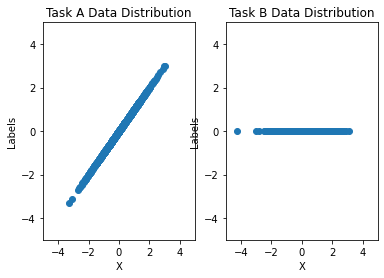

In [3]:
#Create the Task A dataset
X, y, coef = make_regression(n_samples=1000, n_features=1, n_informative=1, noise=0.1, coef=True, bias=0.0)

#Use linear regression to find the true values
regressor = LinearRegression()
regressor.fit(X, y)

#Plot the actual Task A data of y = x
y = (y - regressor.intercept_) / regressor.coef_
y = y.reshape(X.shape[0], -1)
regressor.fit(X, y)

fig = plt.figure()
a1 = fig.add_subplot(1,2,1)
a2 = fig.add_subplot(1,2,2)

a1.scatter(X, y)
a1.set_title('Task A Data Distribution')
a1.set_xlabel('X')
a1.set_ylabel('Labels')
a1.set_xlim([-5, 5])
a1.set_ylim([-5, 5])

print('slope = ' + str(regressor.coef_))
print('intercept = ' + str(regressor.intercept_))
print('y = ' + str(regressor.coef_[0]) + 'x + ' + str(regressor.intercept_))

task_A_data = np.append(X, y, axis=1)

#Task B data
X, y, coef = make_regression(n_samples=1000, n_features=1, n_informative=1, noise=0.1, coef=True, bias=0.0)
regressor = LinearRegression()
regressor.fit(X, y)
y = ((y - regressor.intercept_) / regressor.coef_)
y = y.reshape(X.shape[0], -1) - X

a2.scatter(X, y)
a2.set_title('Task B Data Distribution')
a2.set_xlabel('X')
a2.set_ylabel('Labels')
a2.set_xlim([-5, 5])
a2.set_ylim([-5, 5])

task_B_data = np.append(X, y, axis=1)

In [28]:
def createTaskDatasets(sample_size):
    # Create the Task A dataset
    X, y, coef = make_regression(n_samples=sample_size, n_features=1, n_informative=1, noise=0.1, coef=True, bias=0.0)

    # Use linear regression to find the true values
    regressor = LinearRegression()
    regressor.fit(X, y)
    
    # Rescale y = mx + b to be y* = x, where y* = (y - b) / m
    y = (y - regressor.intercept_) / regressor.coef_
    y = y.reshape(X.shape[0], -1)
    
    task_A_data = np.append(X, y, axis=1)
    
    # Test B data
    X_new, y_new = make_regression(n_samples=sample_size, n_features=1, n_informative=1, noise=0.1, bias=0.0)
    regressor.fit(X_new, y_new)
    y_new = ((y_new - regressor.intercept_) / regressor.coef_)
    y_new = y_new.reshape(X.shape[0], -1) - X_new

    task_B_data = np.append(X_new, y_new, axis=1)
    
    return task_A_data, task_B_data

In [29]:
def experiment(n_task_A, n_task_B, n_test=0.25, n_trees=10, max_depth=None, cur_depth=None, acorn=None):
    
    if acorn != None:
        np.random.seed(acorn)
        
    errors = np.zeros(3, dtype=float)
    
    transformer_voter_decider_split = [0.67, 0.33, 0]
    
    default_transformer_class = TreeRegressionTransformer
    taskA_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}
    taskB_transformer_kwargs = {"kwargs": {"max_depth": cur_depth}}

    #Not implemented
#     taskB_transformer_class = TreeRegressionRandomTransformer

    default_voter_class = TreeRegressionVoter
    default_voter_kwargs = {}

    default_decider_class = KNNRegressionDecider
    default_decider_kwargs = {}

    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                             default_transformer_kwargs = taskA_transformer_kwargs,
                                             default_voter_class = default_voter_class,
                                             default_voter_kwargs = default_voter_kwargs,
                                             default_decider_class = default_decider_class,
                                             default_decider_kwargs = default_decider_kwargs)

    # Create data
    taskA_data, taskB_data = createTaskDatasets(n_task_A)
    
    # Split task data into train/test
    taskA_x_train, taskA_x_test, taskA_label_train, taskA_label_test = train_test_split(taskA_data[:,0], 
                                                                                        taskA_data[:,1], 
                                                                                        test_size=n_test, 
                                                                                        random_state=7)

    taskB_x_train, taskB_x_test, taskB_label_train, taskB_label_test = train_test_split(taskB_data[:,0], 
                                                                                        taskB_data[:,1], 
                                                                                        test_size=n_test, 
                                                                                        random_state=7)
    
    taskA_x_train = taskA_x_train.reshape(-1, 1)
    taskA_x_test = taskA_x_test.reshape(-1, 1)
    taskA_label_train = taskA_label_train.reshape(-1, 1)
    taskA_label_test = taskA_label_test.reshape(-1, 1)

    taskB_x_train = taskB_x_train.reshape(-1, 1)
    taskB_x_test = taskB_x_test.reshape(-1, 1)
    taskB_label_train = taskB_label_train.reshape(-1, 1)
    taskB_label_test = taskB_label_test.reshape(-1, 1)

    if (n_task_A == 0):
        progressive_learner.add_task(taskB_x_train, taskB_label_train)
        l2f_taskB = progressive_learner.predict(taskB_x_test, transformer_ids=[0], task_id=0)

        errors[0] = 0.5
        errors[1] = mean_squared_error(lf2_taskB, taskB_label_test)
        
    elif (n_task_B == 0):
        progressive_learner.add_task(taskA_x_train, taskA_label_train)
        l2f_taskA = progressive_learner.predict(taskA_x_test, transformer_ids=[0], task_id=0)

        errors[0] = mean_squared_error(l2f_taskA, taskA_label_test)
        errors[1] = 0.5
        
    else:
        # Add tasks to progressive learner
        progressive_learner.add_task(taskA_x_train, taskA_label_train)
#         progressive_learner.add_task(taskB_x_train, taskB_label_train)
        
        # Predict and record loss without adversarial transformer
        l2f_taskA = progressive_learner.predict(taskA_x_test, transformer_ids=[0], task_id=0)
        errors[0] = mean_squared_error(l2f_taskA, taskA_label_test)
        
        # Create adversarial transformer
        progressive_learner.add_transformer(taskB_x_train, taskB_label_train,
                                            transformer_class=default_transformer_class,
                                            transformer_kwargs=taskB_transformer_kwargs,
                                            voter_class=default_voter_class,
                                            voter_kwargs=default_voter_kwargs,
                                            transformer_id=1
                                           )
        # Predict and record loss with adversarial transformer
        l2f_taskA_adversarial = progressive_learner.predict(taskA_x_test, transformer_ids=[0, 1], task_id=0)
        errors[1] = mean_squared_error(l2f_taskA_adversarial, taskA_label_test)
        
        # Predict with inference through adversarial 
        l2f_taskA_adversarial_only = progressive_learner.predict(taskA_x_test, transformer_ids=[1], task_id=0)
        errors[2] = mean_squared_error(l2f_taskA_adversarial_only, taskA_label_test)
        
    return errors

In [30]:
# Set up the tree parameters
mc_rep = 100
n_test = 0.25
n_trees = 10
n_sample_size = 1000
max_depth = 30

range_depths = (100*np.arange(0.01, 0.31, step=0.01)).astype(int)

# Initiate error arrays
mean_error = np.zeros((3, len(range_depths)))
std_error = np.zeros((3, len(range_depths)))

# Initiate transfer efficiencies
mean_te = np.zeros((1, len(range_depths)))
std_te = np.zeros((1, len(range_depths)))

for i, n1 in enumerate(range_depths):
    print('starting to compute, depth=%s\n' %n1)
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment)(
                n_sample_size, n_sample_size, n_test=n_test, n_trees=n_trees, cur_depth=n1, max_depth=max_depth
            ) for _ in range(mc_rep)
        )
    )
    mean_error[:, i] = np.mean(error, axis=0)
    std_error[:, i] = np.std(error, ddof=1, axis=0)
    
    mean_te[0, i] = np.mean(error[:, 0]) / np.mean(error[:, 1])
        

with open('./data/mean_taskA_taskB.pickle', 'wb') as f:
    pickle.dump(mean_error, f)
    
with open('./data/std_taskA_taskB.pickle', 'wb') as f:
    pickle.dump(std_error, f)

with open('./data/mean_te_taskA_taskB.pickle', 'wb') as f:
    pickle.dump(mean_te, f)

starting to compute, depth=1



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=2



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=3



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=4



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=5



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=6



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    4.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=6



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=8



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=9



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    4.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=10



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=11



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=12



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    5.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=13



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=14



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    4.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=15



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=16



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=17



[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=18



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=19



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    5.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=20



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=21



[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=22



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=23



[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=24



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=25



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    5.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=26



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=27



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=28



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    5.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=29



[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=30



[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished


Text(0, 0.5, 'Generalization Error')

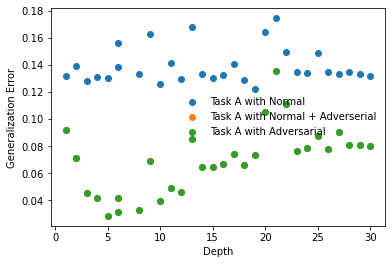

In [31]:
with open('data/mean_taskA_taskB.pickle','rb') as f:
    mean_error = pickle.load(f)
    
range_depths = (100*np.arange(0.01, 0.31, step=0.01)).astype(int)

plt.scatter(range_depths, mean_error[0,:], label='Task A with Normal')
plt.scatter(range_depths, mean_error[1,:], label='Task A with Normal + Adverserial')
plt.scatter(range_depths, mean_error[2,:], label='Task A with Adversarial')
plt.legend(loc='right', frameon=False)
plt.xlabel('Depth')
plt.ylabel('Generalization Error')

In [ ]:
mean_error